<a href="https://colab.research.google.com/github/Poornimatagaram/E-commerce-dataset---Linear-Regression/blob/main/X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set base directory
base_path = '/content/drive/MyDrive/CSV_files'

# CSV file paths
train_csv_path = os.path.join(base_path, 'train-small.csv')
valid_csv_path = os.path.join(base_path, 'valid-small.csv')
test_csv_path = os.path.join(base_path, 'test.csv')
IMAGE_DIR = os.path.join(base_path, 'images-small')

# Load the CSVs
train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)
test_df = pd.read_csv(test_csv_path)

# Display first 5 rows of training data
train_df.head(5)


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [ ]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

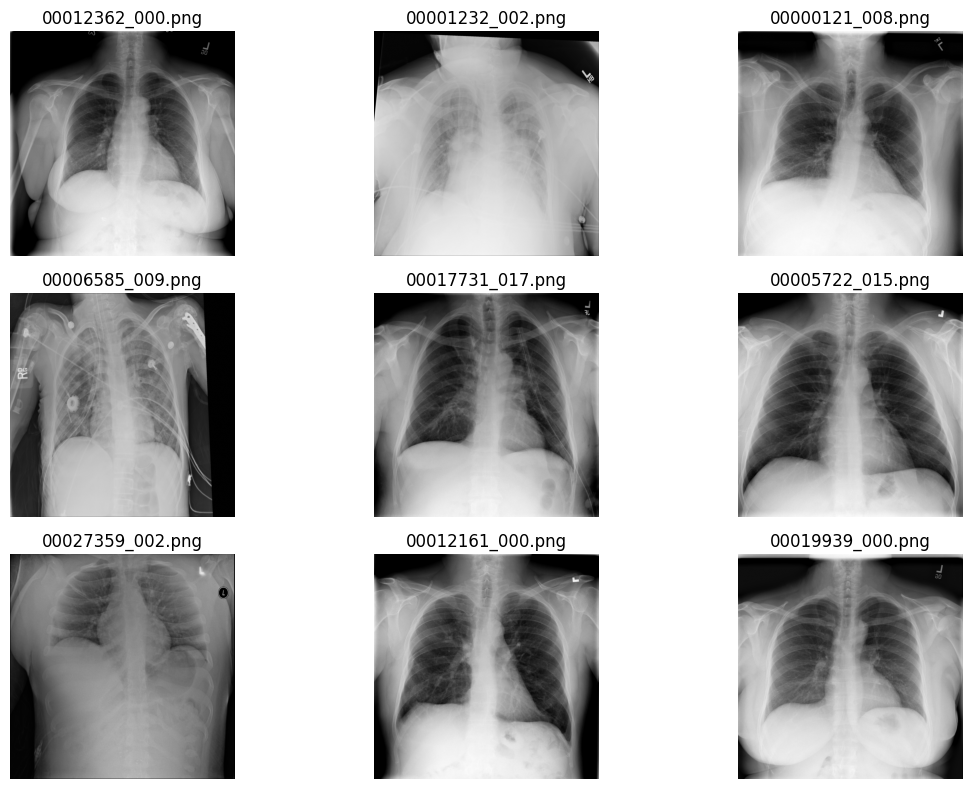

In [ ]:
import matplotlib.image as mpimg

# Extract image filenames
images = train_df['Image'].values

# Pick 9 random images
random_images = np.random.choice(images, size=9, replace=False)

# Plot
plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(IMAGE_DIR, random_images[i])
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(random_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


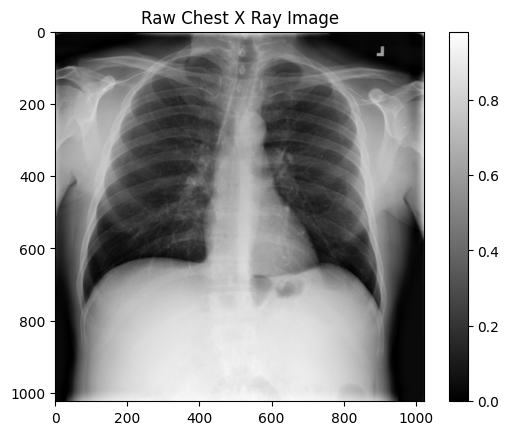

In [ ]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(IMAGE_DIR, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Make use of python's set.intersection() function. </li>
</ul>
</p>

In [ ]:
# Checking for Data Leakage
def check_for_leakage(df1, df2, patient_col):

    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0

    return leakage

In [ ]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = next(raw_train_generator)

    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

**Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions.**


These in turn can be used by physicians to diagnose 8 different diseases.

* We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies.


*   In other words it will predict 'positive' or 'negative' for each of the pathologies.


we have processed the labels for our small sample and generated three new files to get you started. These three files are:

nih/train-small.csv: 875 images from our dataset to be used for training.

nih/valid-small.csv: 109 images from our dataset to be used for validation.

nih/test.csv: 420 images from our dataset to be used for testing.


This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:

* Consolidation
* Edema
* Effusion
* Cardiomegaly
* Atelectasis



In [ ]:
IMAGE_DIR = os.path.join(base_path, 'images-small')
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


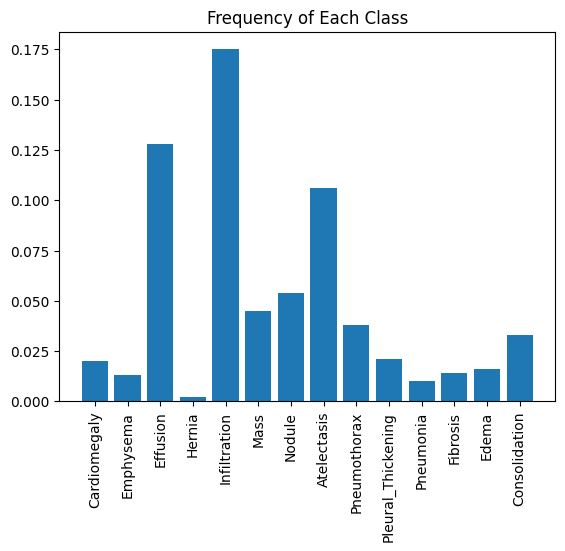

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [ ]:
def compute_class_freqs(labels):

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

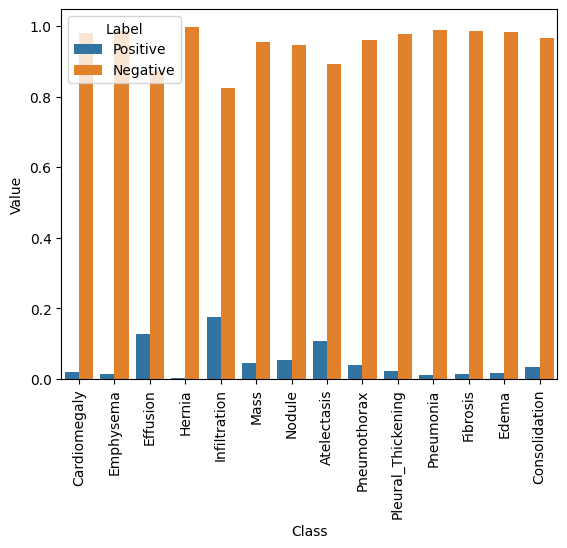

In [ ]:
# Create initial DataFrame with Positive values
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# Create a DataFrame for Negative values
neg_data = pd.DataFrame(
    [{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)]
)

# Combine the two DataFrames
data = pd.concat([data, neg_data], ignore_index=True)

# Plot
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)


In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

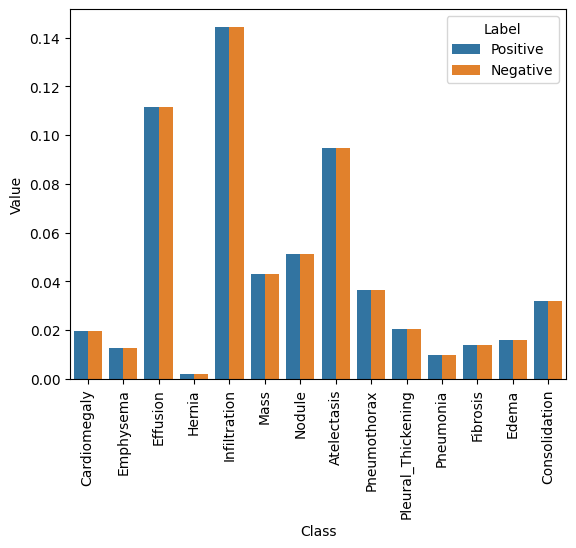

In [ ]:
# Create DataFrame for positive contribution
data = pd.DataFrame({
    "Class": labels,
    "Label": "Positive",
    "Value": pos_contribution
})

# Create DataFrame for negative contribution
neg_data = pd.DataFrame([
    {"Class": labels[l], "Label": "Negative", "Value": v}
    for l, v in enumerate(neg_contribution)
])

# Concatenate both DataFrames
data = pd.concat([data, neg_data], ignore_index=True)

# Plot
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data);


In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg

        return loss

        ### END CODE HERE ###
    return weighted_loss

In [ ]:
# Create the base pre-trained model
base_model = DenseNet121(weights=os.path.join(base_path, 'densenet.hdf5'), include_top=False);


x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [ ]:
model.load_weights("/content/drive/MyDrive/CSV_files/pretrained_model.h5")

In [ ]:

predicted_vals = model.predict(test_generator, steps=len(test_generator))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/CSV_files')

import util



/content/drive/MyDrive/CSV_files/util.py:96: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/content/drive/MyDrive/CSV_files/util.py:96: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/content/drive/MyDrive/CSV_files/util.py:96: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/content/drive/MyDrive/CSV_files/util.py:96: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/content/drive/MyDrive/CSV_files/util.py:96: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/content/drive/MyDrive/CSV_files/util.py:96: UserWarning: Ignoring specified arguments in this call because figure with 

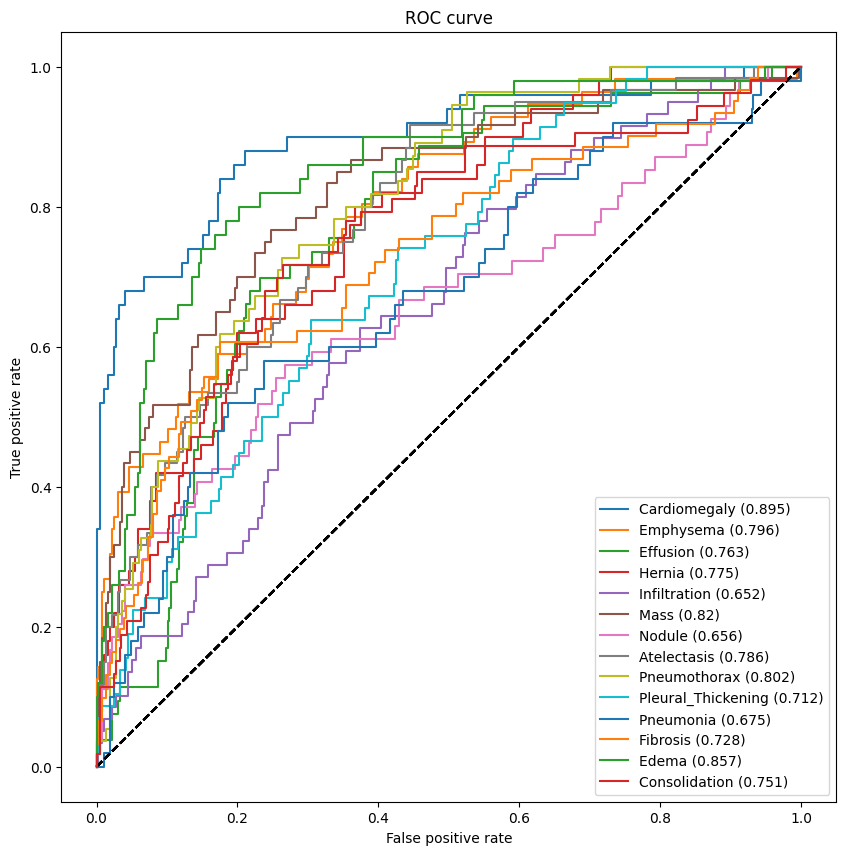

In [ ]:
from util import get_roc_curve


auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CSV_files/train-small.csv")
IMAGE_DIR = "/content/drive/MyDrive/CSV_files/images-small/"




In [ ]:
#only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def compute_gradcam(model, image_file, image_dir, df, labels, labels_to_show, last_conv_layer_name='conv5_block16_2_conv', img_size=(120,120)):
    """
    Shows Grad-CAMs for selected labels side by side.
    """
    img_path = os.path.join(image_dir, image_file)
    print(f"Loading original image: {img_path}")

    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, img_size)
    img_array = img_resized / 255.0
    input_tensor = np.expand_dims(img_array, axis=0)

    # Create grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Setup subplot
    n_labels = len(labels_to_show)
    fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4))

    if n_labels == 1:
        axes = [axes]

    for i, label in enumerate(labels_to_show):
        try:
            class_idx = labels.index(label)
        except ValueError:
            print(f"Label {label} not found.")
            continue

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(input_tensor)
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
        heatmap = heatmap.numpy()

        # Resize heatmap and overlay
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap_color * 0.4 + img

        # Show subplot
        axes[i].imshow(np.uint8(superimposed_img))
        axes[i].set_title(f"{label}", fontsize=12)
        axes[i].axis('off')

    plt.suptitle(f"Grad-CAM for {image_file}", fontsize=14)
    plt.tight_layout()
    plt.show()


Loading original image: /content/drive/MyDrive/CSV_files/images-small/00008270_015.png


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1728']]
Received: inputs=Tensor(shape=(1, 120, 120, 3))
  warnings.warn(msg)


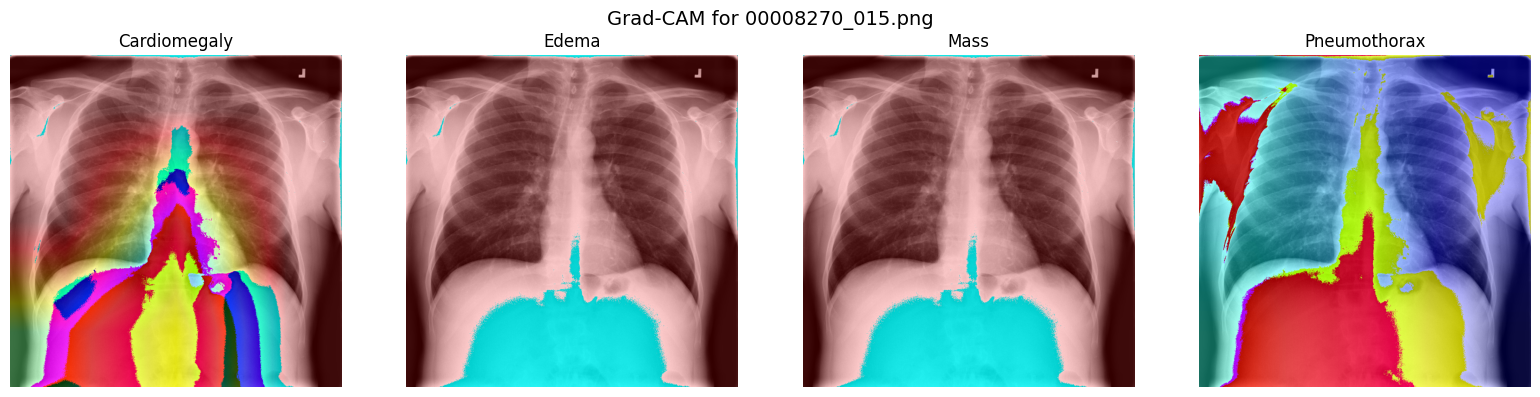

In [ ]:
compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)


Loading original image: /content/drive/MyDrive/CSV_files/images-small/00011355_002.png


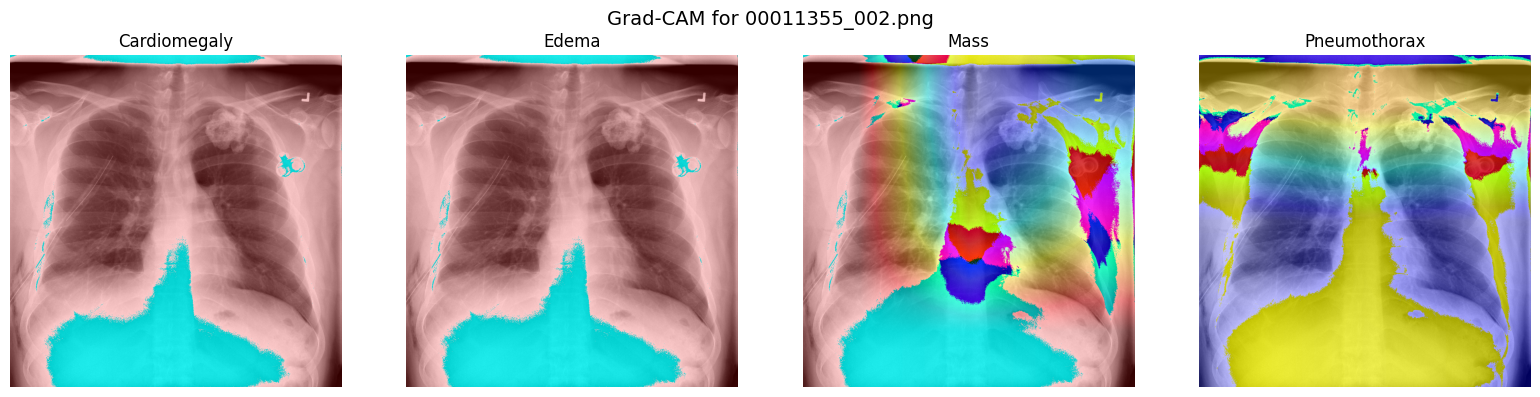

In [ ]:
compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image: /content/drive/MyDrive/CSV_files/images-small/00029855_001.png


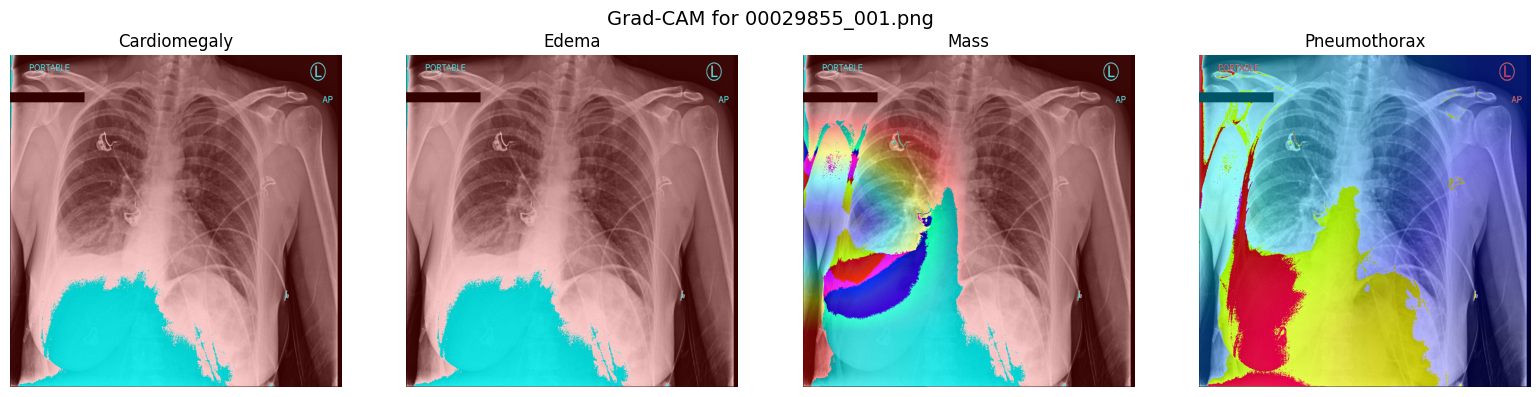

In [ ]:
compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image: /content/drive/MyDrive/CSV_files/images-small/00005410_000.png


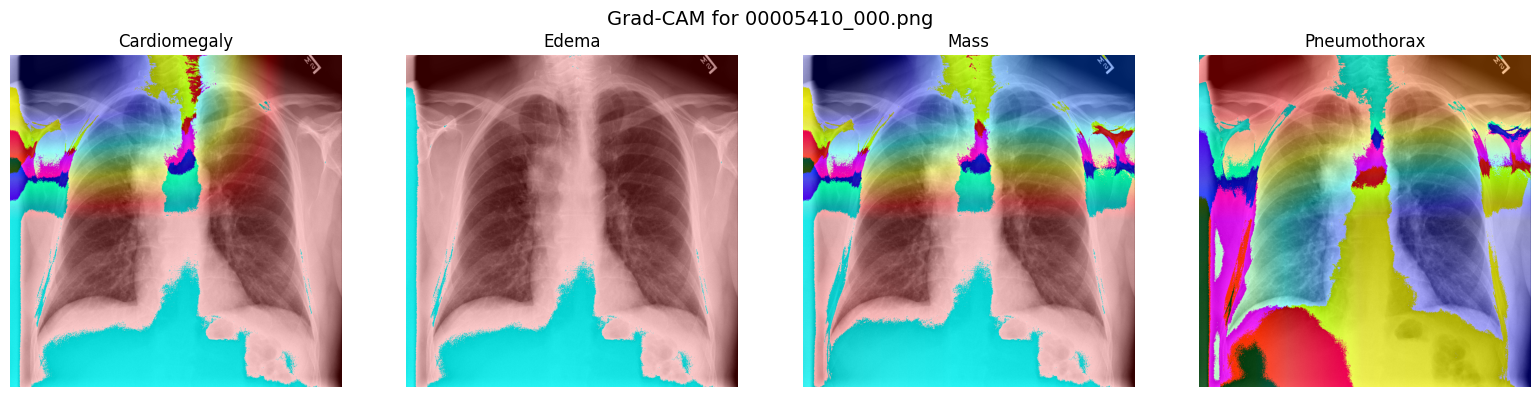

In [ ]:
compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)